# Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from collections import Counter
import string
import pickle
from tqdm import tqdm, tqdm_notebook

# Load and Preprocess Data

### Define directory

In [2]:
path = '/kaggle/input/flickr-8k-images/Flickr8k'
images_directory = path + '/Flickr8k_Dataset/Flicker8k_Dataset'
captions_path = path + '/Flickr8k_text/Flickr8k.token.txt'

### Load File

In [3]:
def load_captions(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [4]:
all_ids_captions  = load_captions(captions_path)
all_ids_captions  = all_ids_captions.split('\n')
    
all_ids_captions [:6]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting']

In [5]:
def visualize_img_with_captions(img_id):
    
    # filter the specific img
    lines = [line for line in all_ids_captions if img_id in line]
    img_path = images_directory + '/' + lines[0].split('\t')[0][:-2]
    captions = [line.split('\t')[1] for line in lines]
    
    # Create subplots for image and captions
    fig, (ax_img, ax_captions) = plt.subplots(1, 2, figsize=(10, 5))

    image_load = load_img(img_path, target_size=(299, 299))
    ax_img.imshow(image_load)
    ax_img.axis('off')

    # Display the captions
    ax_captions.axis('off')
    ax_captions.set_xlim(0, 1)
    ax_captions.set_ylim(0, len(captions))

    # Plot the captions
    for i, caption in enumerate(captions):
        ax_captions.text(0, i, caption, fontsize=16)

    plt.show()

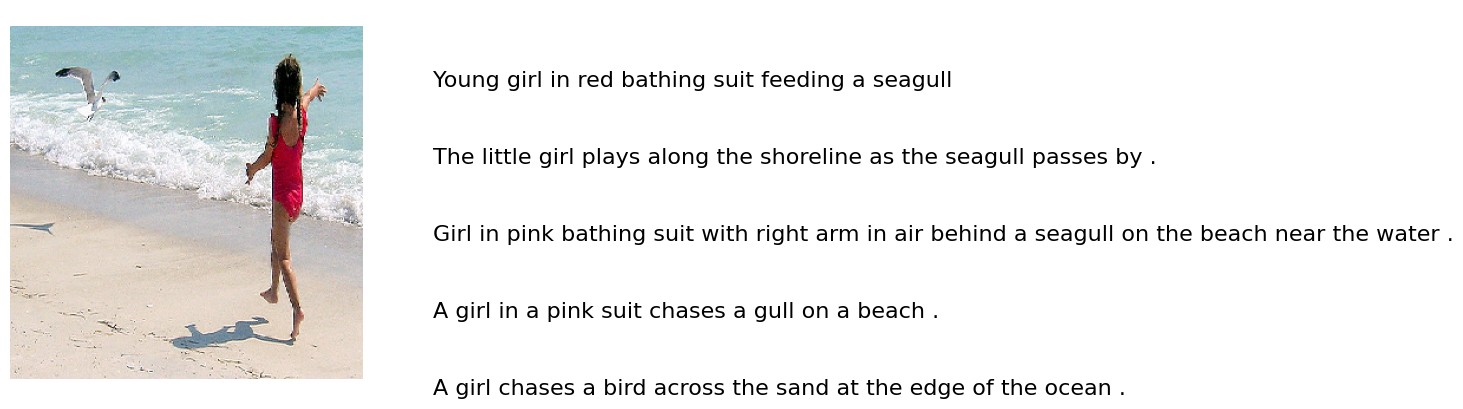

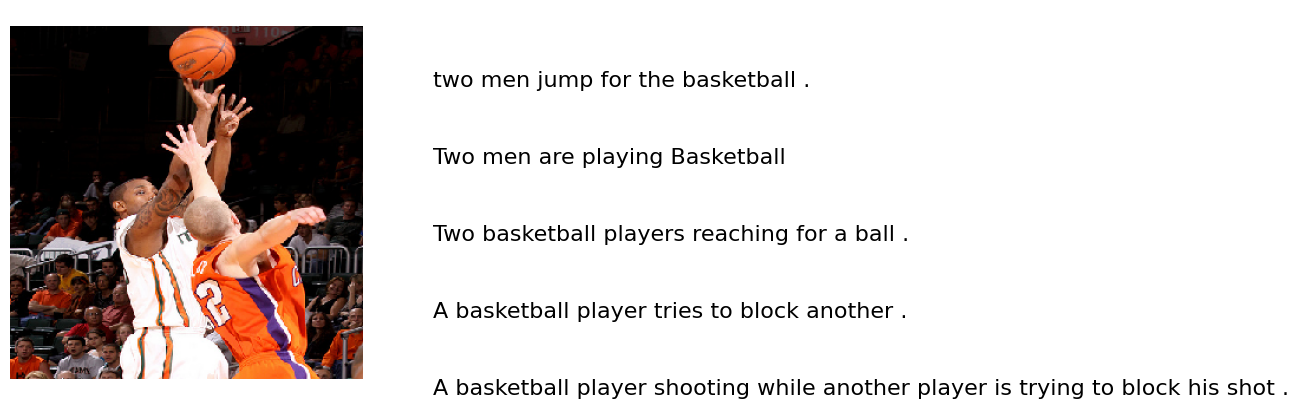

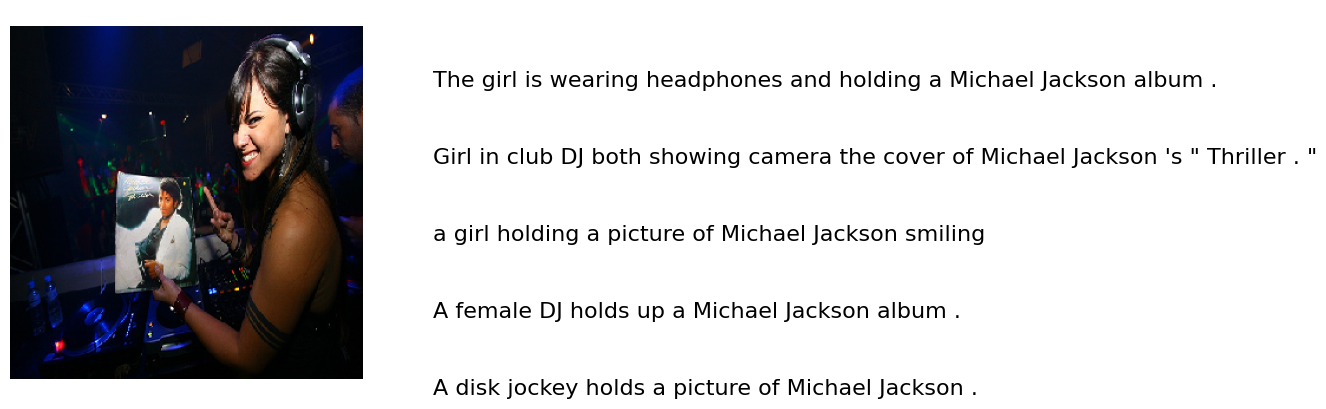

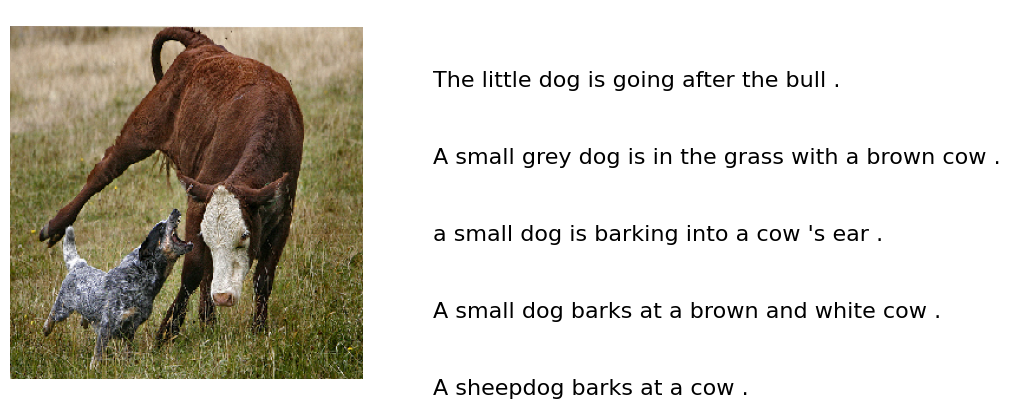

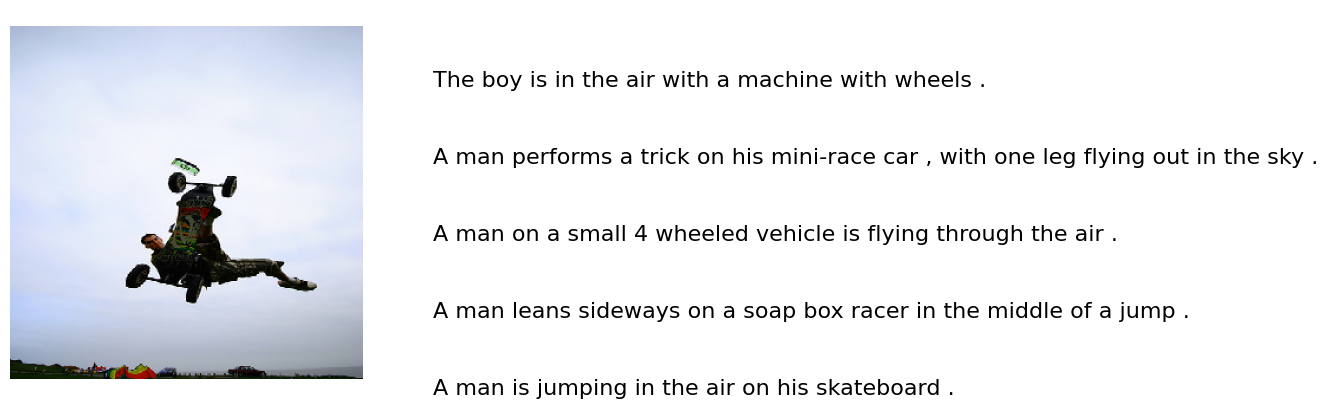

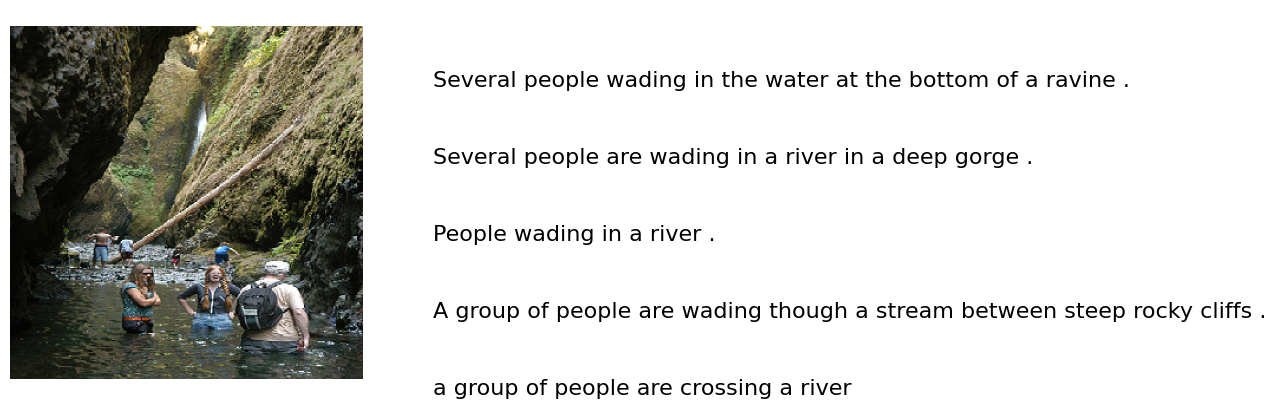

In [6]:
ids = set([item.split('\t')[0][:-2] for item in all_ids_captions])
ids = list(ids)

visualize_img_with_captions(ids[2])
visualize_img_with_captions(ids[3])
visualize_img_with_captions(ids[4])
visualize_img_with_captions(ids[5])
visualize_img_with_captions(ids[6])
visualize_img_with_captions(ids[7])

## Prepare text for model

## Clean captions

In [7]:
def clean_caption(caption):
    # Preapring a translation table for removing all the punctuation
    table = str.maketrans('','', string.punctuation)
    
    caption = caption.split()
    
    # Converting all the words to lower case
    caption = [word.lower() for word in caption]

    # Removing the punctuation using the translation table we made
    caption = [word.translate(table) for word in caption]

    # Removing the words with length =1
    caption = [word for word in caption if len(word)>1]

    # Removing all words with number in them
    caption = [word for word in caption if word.isalpha()]

    return ' '.join(caption)

In [8]:
tokens  = [clean_caption(caption.split('\t')[1]) for caption in all_ids_captions if len(caption) > 2]

tokens[:6]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin',
 'black dog and spotted dog are fighting']

## Tokenizing captions

In [9]:
def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

In [10]:
tokenizer = tokenize_captions(tokens)
vocab_size = len(tokenizer.word_index) + 1

# save tokens in file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
    
vocab_size

8764

In [11]:
# clean captions
# add 'start ' and ' end' to each caption to indicate the beginning and ending of the caption to the model.
# 'girl going into wooden building' -> 'start girl going into wooden building end'
for i in range(len(all_ids_captions)):
    if(len(all_ids_captions[i]) < 2):
        continue
    id = all_ids_captions[i].split('\t')[0][:-2]
    caption = clean_caption('start ' + all_ids_captions[i].split('\t')[1] + ' end')
    all_ids_captions[i] = (id+'\t'+caption)
    
    
all_ids_captions[:6], len(all_ids_captions)

(['1000268201_693b08cb0e.jpg\tstart child in pink dress is climbing up set of stairs in an entry way end',
  '1000268201_693b08cb0e.jpg\tstart girl going into wooden building end',
  '1000268201_693b08cb0e.jpg\tstart little girl climbing into wooden playhouse end',
  '1000268201_693b08cb0e.jpg\tstart little girl climbing the stairs to her playhouse end',
  '1000268201_693b08cb0e.jpg\tstart little girl in pink dress going into wooden cabin end',
  '1001773457_577c3a7d70.jpg\tstart black dog and spotted dog are fighting end'],
 40461)

## Prepare images for model

In [12]:
# Loading InceptionV3 model
inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)


def extract_image_features(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    features = inception_v3_model.predict(img, verbose=0)
    return features.flatten()

96112376/96112376 [==============================] - 1s 0us/step


## Extract image features

In [13]:
all_imgs_features = {}

# Storing all ids
all_image_ids = os.listdir(images_directory)

for id in tqdm(all_image_ids):
    all_imgs_features[id] = extract_image_features(images_directory + '/' + id)

100%|██████████| 8091/8091 [11:43<00:00, 11.49it/s]


# Splitting The Data Into Tain, Test and Validation

In [14]:
# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for line in all_ids_captions:
    if(len(line) < 2):
        continue
    
    image_id = line.split('\t')[0]
    
    if image_id in train_image_ids:
        train_captions.append(line)
        
    elif image_id in val_image_ids:
        val_captions.append(line)        

    elif image_id in test_image_ids:
        test_captions.append(line)

    
train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart child in pink dress is climbing up set of stairs in an entry way end',
 '1001773457_577c3a7d70.jpg\tstart black dog and spotted dog are fighting end',
 '1042590306_95dea0916c.jpg\tstart man and woman pose for the camera while another man looks on end',
 6877.0,
 1092.0,
 122.0)

In [15]:
train_image_features, val_image_features, test_image_features = {}, {}, {}     

for image_id in all_imgs_features.keys():
    
    if image_id in train_image_ids:
        train_image_features[image_id] = all_imgs_features[image_id]
    
    elif image_id in val_image_ids:
        val_image_features[image_id] = all_imgs_features[image_id]
    
    elif image_id in test_image_ids:
        test_image_features[image_id] = all_imgs_features[image_id]

# Model setup

In [16]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                seq = tokenizer.texts_to_sequences([caption_text])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)
            
            yield [np.array(X_images), np.array(X_captions)], np.array(y)
         
        
# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in tokens) + 1

# Defining batch size
batch_size_train = 64
batch_size_val = 32

# Creating data generators for training and validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [17]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = BatchNormalization()(fe2)
    
    # Decoder Model
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)
    
    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model
    

# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = inception_v3_model.output_shape[1] # 2048

# Building the model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features_Input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, 2048)        8192        ['Features_Input[0][0]']         
 ormalization)                                                                                    
                                                                                                  
 Sequence_Input (InputLayer)    [(None, 33)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          524544      ['batch_normalizat

# Train the model

In [18]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

caption_model.save('caption_model.h5')

Epoch 1/15
537/537 [==============================] - 89s 152ms/step - loss: 4.6418 - val_loss: 4.0282 - lr: 0.0055
Epoch 2/15
537/537 [==============================] - 63s 118ms/step - loss: 3.6209 - val_loss: 3.7970 - lr: 0.0030
Epoch 3/15
537/537 [==============================] - 63s 118ms/step - loss: 3.2594 - val_loss: 3.7588 - lr: 0.0017
Epoch 4/15
537/537 [==============================] - 64s 119ms/step - loss: 3.0323 - val_loss: 3.7573 - lr: 9.0718e-04
Epoch 5/15
537/537 [==============================] - 63s 118ms/step - loss: 2.8843 - val_loss: 3.7605 - lr: 4.9787e-04
Epoch 6/15
537/537 [==============================] - 63s 117ms/step - loss: 2.7907 - val_loss: 3.7784 - lr: 2.7324e-04
Epoch 7/15
537/537 [==============================] - 64s 118ms/step - loss: 2.7351 - val_loss: 3.7893 - lr: 1.4996e-04


# Evaluate the Model

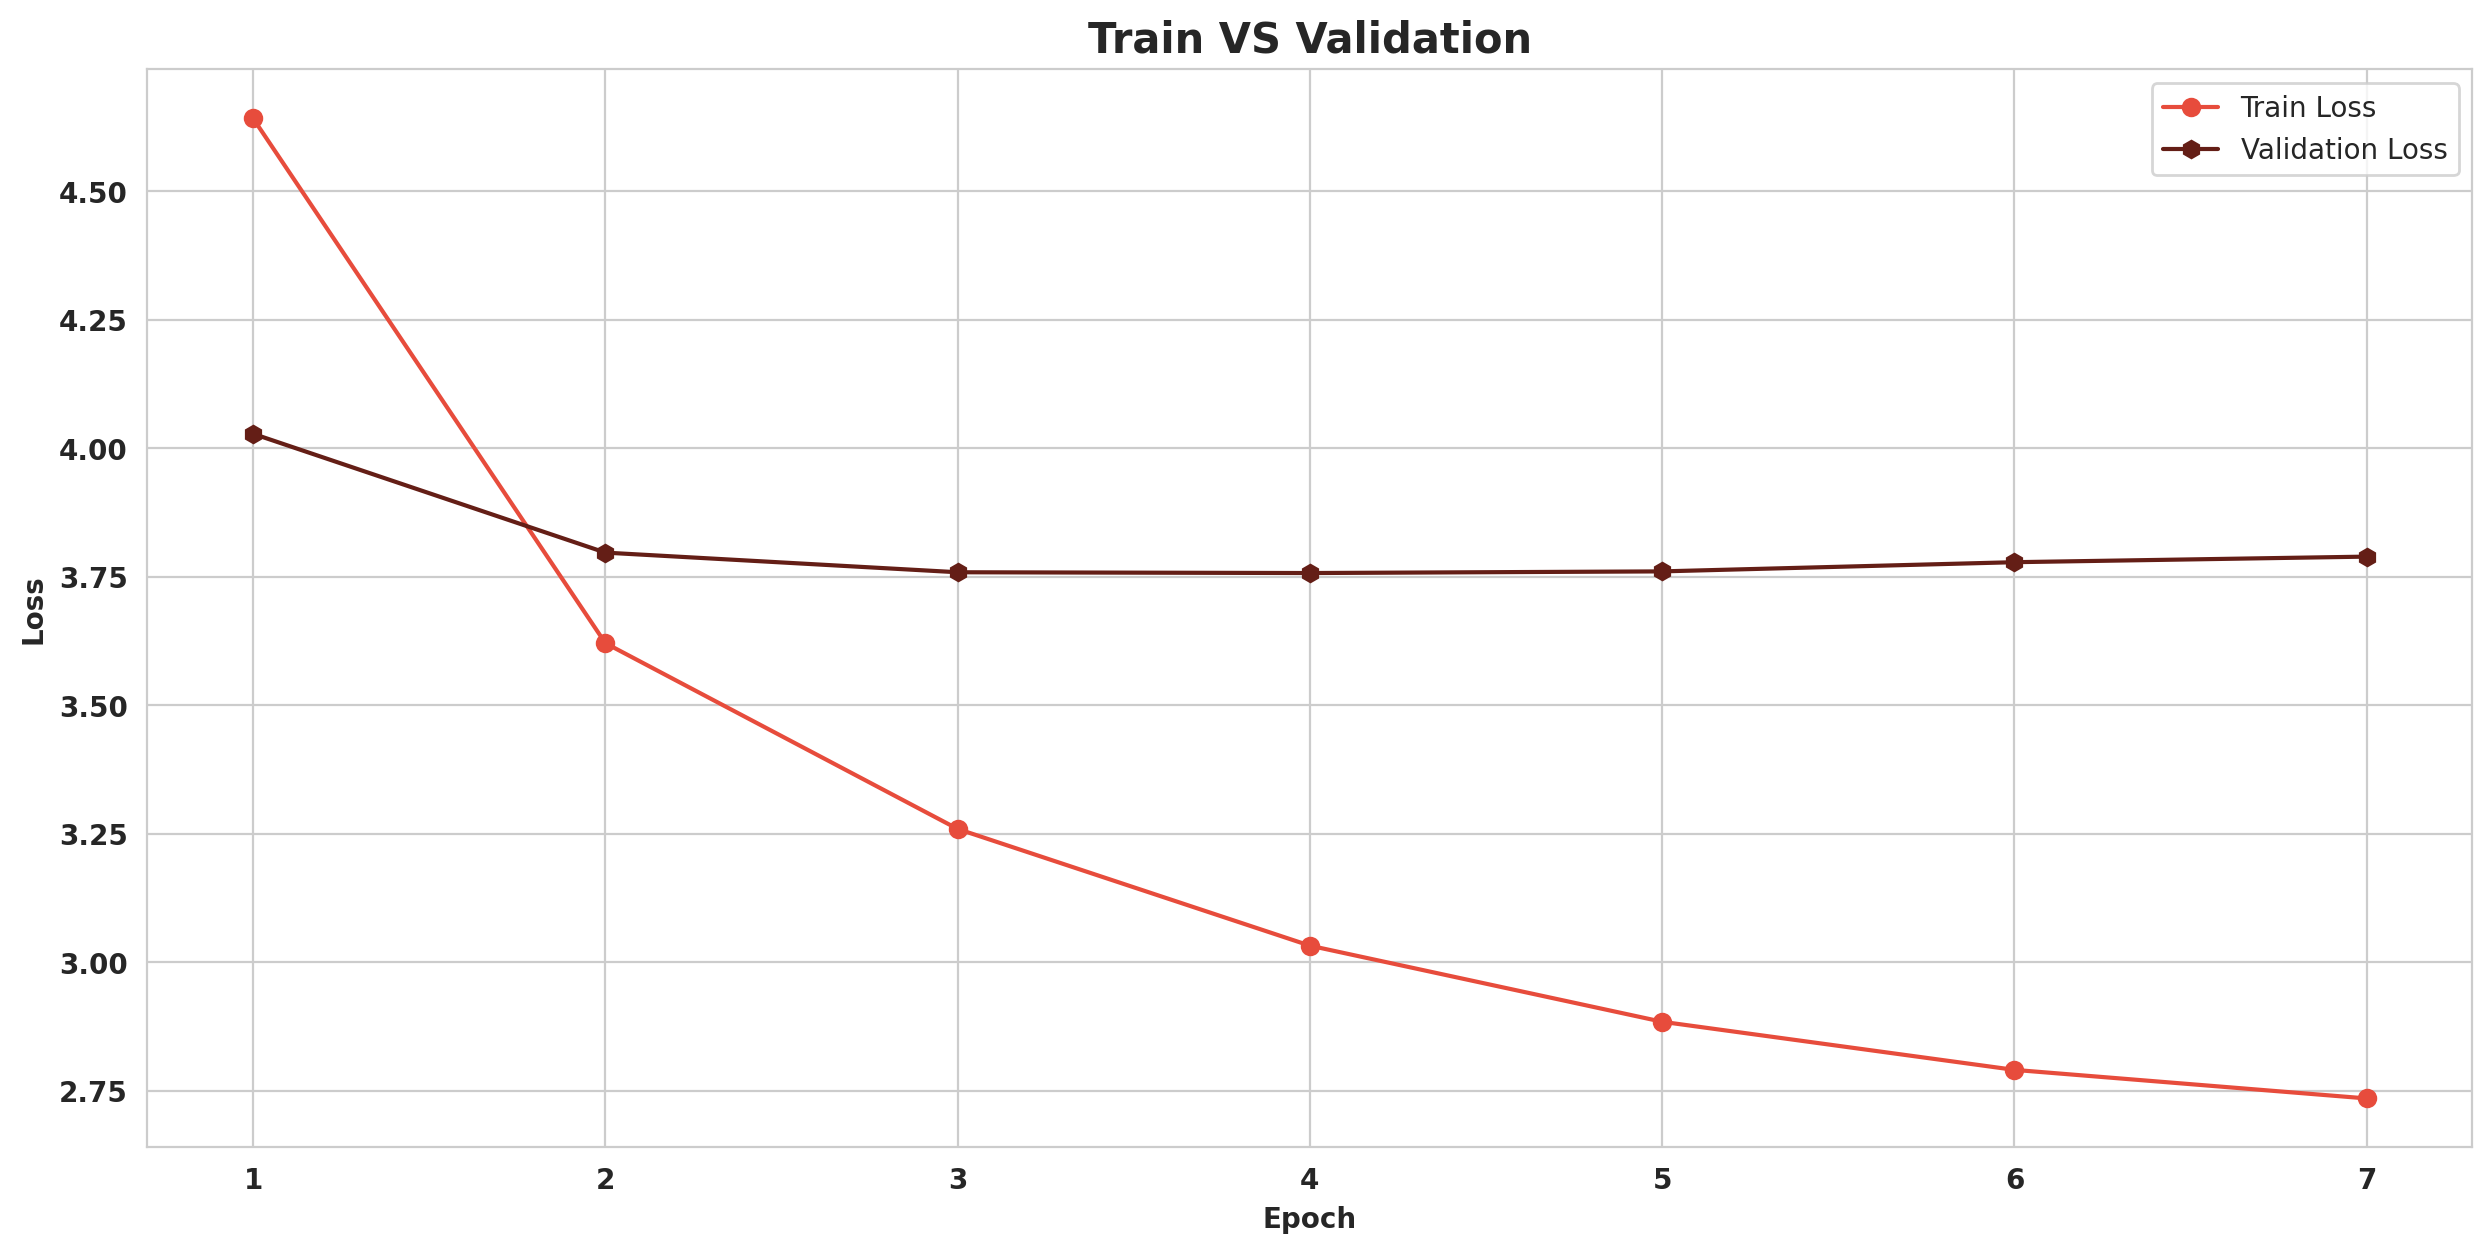

In [19]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [20]:
# Function to generate captions
def greedy_generator(image_features): 
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word
        # When the model returns the word 'end' (which is the end word), the generating loop must be stopped 
        if word == 'end':
            break
            
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    
    return in_text

In [21]:
# Calculates BLEU score of predictions
def BLEU_score(actual, greedy):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    
    return [
        (f'BLEU-2 Greedy: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_greedy_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
    ]

In [22]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [23]:
# Generating captions
generated_captions = {}

for image_id in tqdm(test_image_features):
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap

100%|██████████| 122/122 [01:12<00:00,  1.68it/s]


# Make Predictions

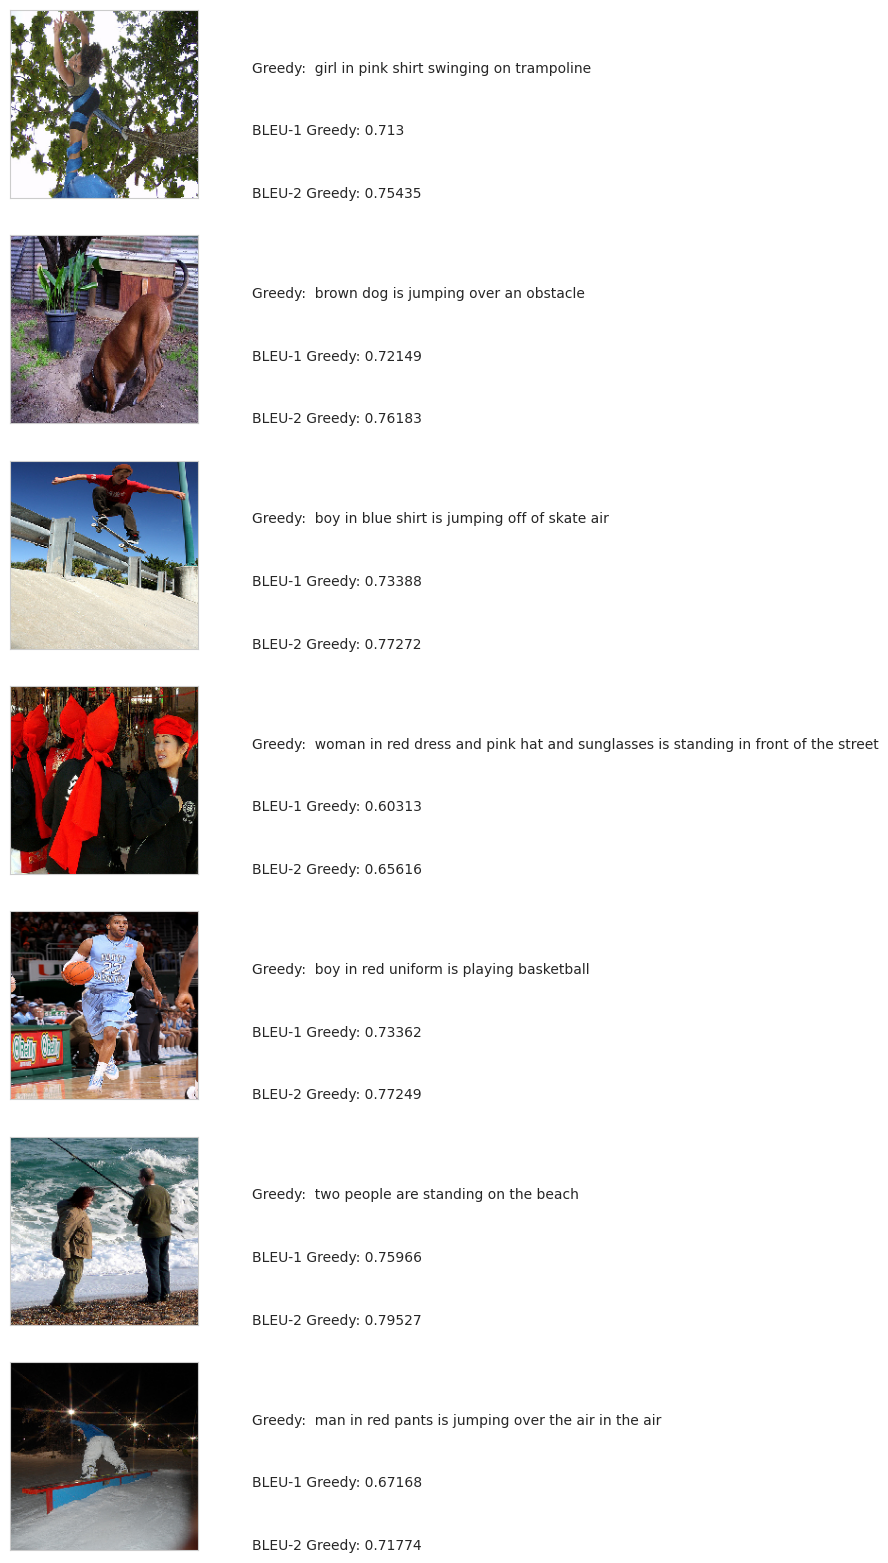

In [24]:
def visualization(data, greedy_caps, evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    
    count = 1
    fig = plt.figure(figsize=(6,20))    
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" end", "") for x in actual_cap] # Removing the end token
        
        # Generating captions
        greedy_cap = greedy_caps[filename]
        
        # Getting the bleu score
        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)))
    
        image_load = load_img(images_directory+ '/' +filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

visualization(test_actual_captions, generated_captions, BLEU_score, 7)